# Creating WTs

This notebook contains code for:
- importing necessary libraries
- dowloading and preprocessing the dataset
- using the dataset to train the full model and save the accuracies
- performing IMP (with rewinding) using the model and datset
- comparing pruned and unpruned model accuracies
- saving sparse model weights of WTs in Folder

In [1]:
# importing necessary libraries and the cnn architecture I defined

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
import copy

2024-05-08 16:52:56.809610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# shape of the model weights

train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=60, shuffle_size=512)
model = CNN2Model()
model(list(train_dataset)[0][0])

weights = model.get_weights()
biases = weights[1::2]
not_biases = weights[0::2]

for w in weights:
    print(w.shape)

2024-05-08 16:53:01.000053: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-08 16:53:01.203334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2024-05-08 16:53:01.203727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(16384, 256)
(256,)
(256, 256)
(256,)
(256, 10)
(10,)


### Train Loop and IMP loop

In [3]:
# modified train loop to also work with sparse networks (such that pruned weights remain frozen at 0.0)

def train_loop_sparse(train, test, model, num_epochs=5):
    
    # hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializing training statistics
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for epoch in tqdm(range(num_epochs), leave=False, desc="training epochs"):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # set gradients to zero for all pruned weights
            new_gradients = []
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
                new_gradients.append(gradient_matrix)
            optimizer.apply_gradients(zip(new_gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        # updataing training statistics
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()     
    
    return  train_acc, test_acc, train_l, test_l

In [4]:
# iterative magnitude pruning

def imp(datasetname, train, test, model, iterations=7, epochs_per_it=5, pruning_rate_conv=15, pruning_rate_dense=30):
    
    # safe initial weights
    initial_weights = model.get_weights()
    
    # initializing training statistics
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []
    pruning_rates = [get_pruning_rates(initial_weights[::2])]   
    
    # iterations
    for i in tqdm(range(iterations), position=0, desc="pruning iterations"):
        
        
        ##################################################
        # Training #######################################
        ##################################################

        train_acc_i, test_acc_i, train_l_i, test_l_i = train_loop_sparse(train, test, model, num_epochs=epochs_per_it)
        train_acc.extend(train_acc_i)
        test_acc.extend(test_acc_i)
        train_l.extend(train_l_i)
        test_l.extend(test_l_i)              
        
        ##################################################
        # Pruning ########################################  
        ##################################################
        

        new_weights = copy.copy(initial_weights)
        
        # prune conv layers layer-wise:
        new_conv_weights = []   
        for conv_current, conv_init in zip(model.get_weights()[0:4:2], initial_weights[0:4:2]):
            
            # calculate percentile
            conv_current_flat = conv_current.flatten()
            conv_unpruned = copy.copy(conv_current_flat[conv_current_flat != 0.0])
            conv_unpruned_abs =  tf.math.abs(conv_unpruned)
            conv_percentile = np.percentile(conv_unpruned_abs, pruning_rate_conv)
            
            # prune according to percentile
            conv_current_pruned = tf.where(tf.math.abs(conv_current) < conv_percentile, 0.0, conv_init)
            new_conv_weights.append(conv_current_pruned)
        
        # replace the unpruned conv layers by the pruned conv layers
        new_weights[0] = new_conv_weights[0] 
        new_weights[2] = new_conv_weights[1]      
        
        #---------
        
        # calculate percentile of dense layer globally
        dense_unpruned_abs_all = []
        for dense_layer in model.get_weights()[4::2]:
            dense_flat = dense_layer.flatten()
            dense_unpruned = copy.copy(dense_flat[dense_flat != 0.0])
            dense_unpruned_abs =  tf.math.abs(dense_unpruned)
            dense_unpruned_abs_all.extend(dense_unpruned_abs)
        dense_percentile = np.percentile(dense_unpruned_abs_all, pruning_rate_dense)
        
        # prune dense layers according to percentile
        new_dense_weights = []
        for dense_current, dense_init in zip(model.get_weights()[4::2], initial_weights[4::2]):
            
            dense_pruned = tf.where(tf.math.abs(dense_current) < dense_percentile, 0.0, dense_init)
            new_dense_weights.append(dense_pruned)
        
        # replace the unpruned dense layers by the pruned dense layers
        new_weights[4] = new_dense_weights[0] 
        new_weights[6] = new_dense_weights[1]
        new_weights[8] = new_dense_weights[2] 

        model.set_weights(new_weights)
        pruning_rates.append(get_pruning_rates(new_weights[::2]))
    
    # plotting the pruning rates for each layer per iteration
    pruning_rates = np.array(pruning_rates)
    fig= plt.figure(figsize=(10,6))
    plt.title(f"Pruning rates IMP {datasetname} all layers")
    plt.xlabel("epochs")
    plt.ylabel("pruning_rates")
    plt.plot(pruning_rates[:,0],label="conv1")
    plt.plot(pruning_rates[:,1],label="conv2")
    plt.plot(pruning_rates[:,2],label="dense1")
    plt.plot(pruning_rates[:,3],label="dense2")
    plt.plot(pruning_rates[:,4],label="dense3")
    plt.legend()
    plt.savefig("3b Plots/{datasetname}_IMP_pruning_rates.png")
    plt.show()
    
    return  train_acc, test_acc, train_l, test_l

In [5]:
# plotting

def plot_losses(datasetname, train_acc, test_acc, train_l, test_l, title):
    fig= plt.figure(figsize=(10,6))
    plt.title(title)
    plt.xlabel("epochs")
    plt.ylabel("Loss/Accuracy")
    plt.plot(test_l,label="test loss")
    plt.plot(train_l,label="training loss")
    plt.plot(test_acc,label="test accuracy")
    plt.plot(train_acc,label="training accuracy")
    plt.legend()
    plt.savefig(f"3b Plots/{datasetname}_IMP_losses.png")
    plt.show()


## Creating winning tickets from scratch

In [6]:
def create_sparse_net(datasetname, train_dataset, test_dataset):
    #########################################
    # 1.:  get initial weight configuration #
    #########################################

    model = CNN2Model()

    #predict something with the model so it initializes the weights
    model(list(train_dataset)[0][0])

    #save the initial weights to reuse for IMP
    initial_weights = model.get_weights()
        
    #########################################################################
    # 2.:  train control model with initial weights to get control accuracy #
    #########################################################################

    control_model = CNN2Model()
    control_model(list(train_dataset)[0][0])
    control_model.set_weights(initial_weights)

    train_acc, test_acc, train_l, test_l = train_loop_sparse(train_dataset, test_dataset, control_model)
    control_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(datasetname, train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for control model")
    
    #######################################################################################
    # 3.:  use initial weights to also perform iterative magnitude pruning on a new model #
    #######################################################################################

    imp_model = CNN2Model()
    imp_model(list(train_dataset)[0][0])
    imp_model.set_weights(initial_weights)

    train_acc, test_acc, train_l, test_l = imp(datasetname, train_dataset, test_dataset, imp_model)
    imp_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(datasetname, train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for iterative magnitude pruning")

    #get resulting sparse network weights
    sparse_weights = imp_model.get_weights()
        
    #############################################################################
    # 4.:  train the resulting sparse network from the start and get accuracies #
    #############################################################################

    sparse_model = CNN2Model()
    sparse_model(list(train_dataset)[0][0])
    sparse_model.set_weights(sparse_weights)

    train_acc, test_acc, train_l, test_l = train_loop_sparse(train_dataset, test_dataset, sparse_model)
    sparse_stats = [train_acc, test_acc, train_l, test_l]
    plot_losses(datasetname, train_acc, test_acc, train_l, test_l,"CNN Loss and Accuracy for sparse network")
    
    return control_stats, sparse_stats, sparse_weights

In [7]:
def create_lottery_tickets(runs, dataset):
    

    train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=60, shuffle_size=512)    
    
    for r in range(runs):
        
        # create sparse network
        control_stats, sparse_stats, sparse_weights = create_sparse_net(dataset, train_dataset, test_dataset)
        control_accuracy = np.max(control_stats[1])
        sparse_accuracy = np.max(sparse_stats[1])
        print("Best accuracy of control model: ", control_accuracy)
        print("Best accuracy of sparse model: ", sparse_accuracy)
        
        # calculate percentage of pruned weights
        print("total pruning rate:", get_pruning_rate(sparse_weights))
        print("layerwise pruning rates:", get_pruning_rates(sparse_weights))
        
        # compare accuracy to check wheter sparse network is winning ticket
        if sparse_accuracy + 0.2 >= control_accuracy:
            print("It's a winning ticket!")
            
            # sovae model weights
            imp_model = CNN2Model()
            imp_model(list(train_dataset)[0][0])
            imp_model.set_weights(sparse_weights)
            imp_model.save_weights(f"./1b WTs/WT_{dataset}_IMP_{r}", save_format="h5", overwrite=True)
            
        else:
            print("It's not a winning ticket.")

2024-05-08 16:53:07.754353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [65932,10]
	 [[{{node Placeholder/_1}}]]
training epochs:   0%|          | 0/5 [00:00<?, ?it/s]2024-05-08 16:57:30.812172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [7325,10]
	 [[{{node Placeholder/_1}}]]


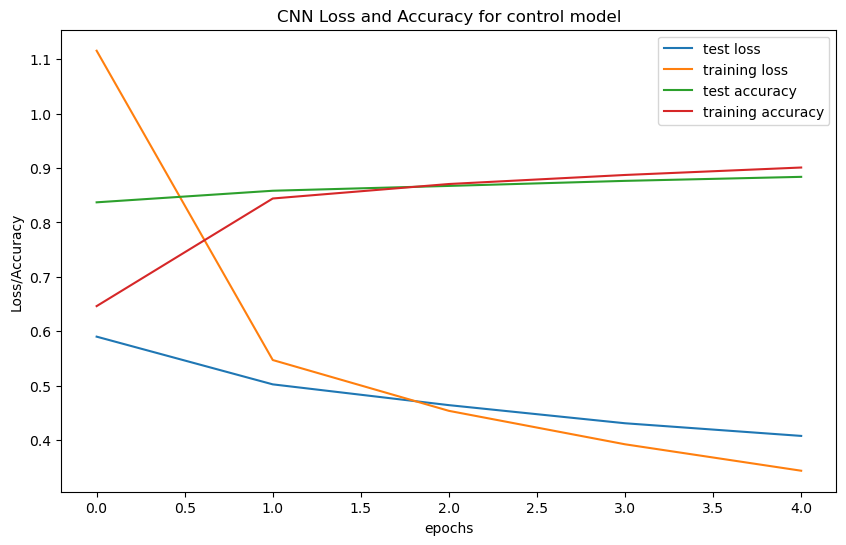

pruning iterations: 100%|██████████| 7/7 [3:27:10<00:00, 1775.75s/it]  


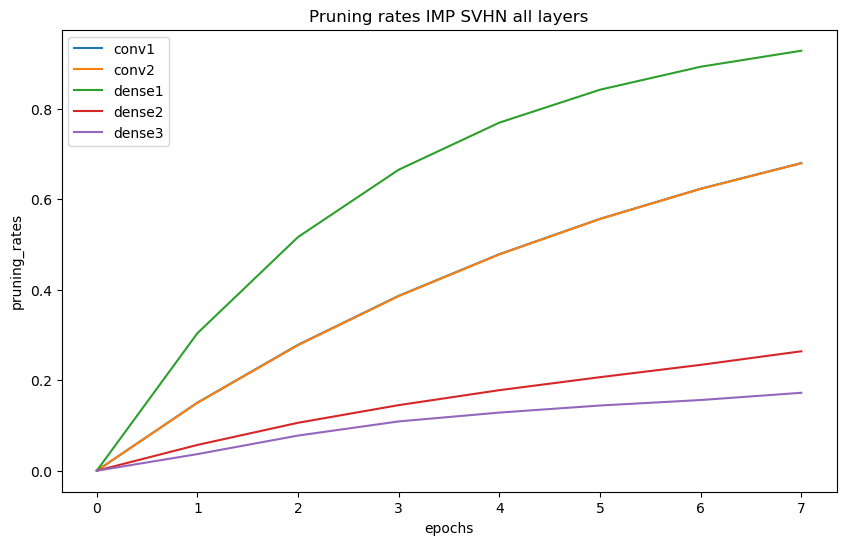

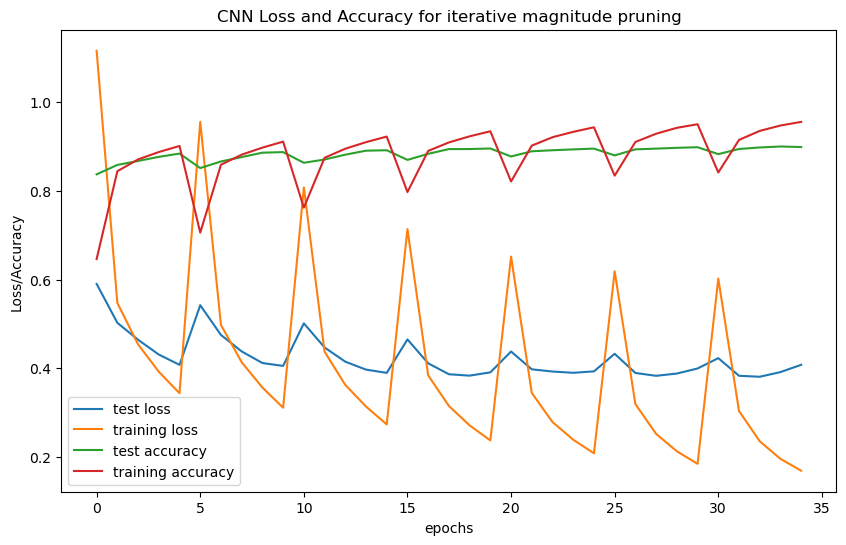

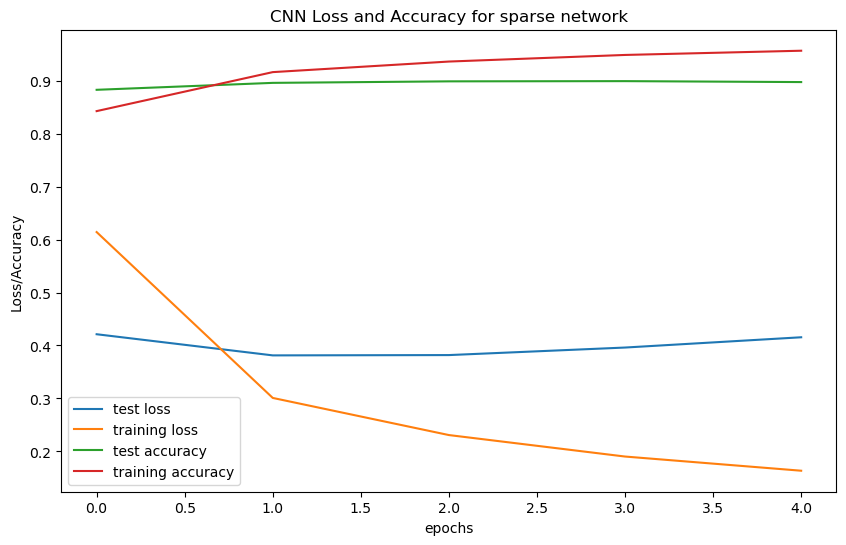

Best accuracy of control model:  0.8838225
Best accuracy of sparse model:  0.89924914
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9283139705657959, 0.0, 0.2639923095703125, 0.0, 0.17226562499999998, 0.0]
It's a winning ticket!


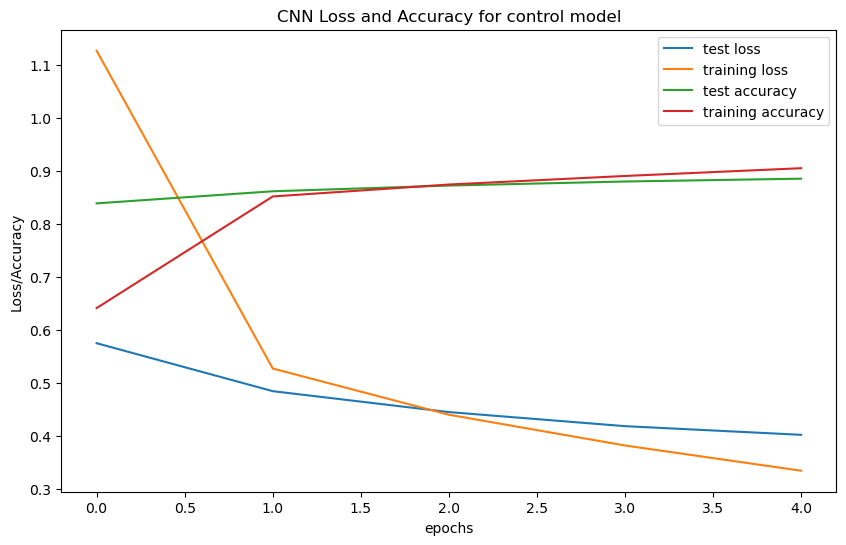

pruning iterations: 100%|██████████| 7/7 [3:24:29<00:00, 1752.86s/it]  


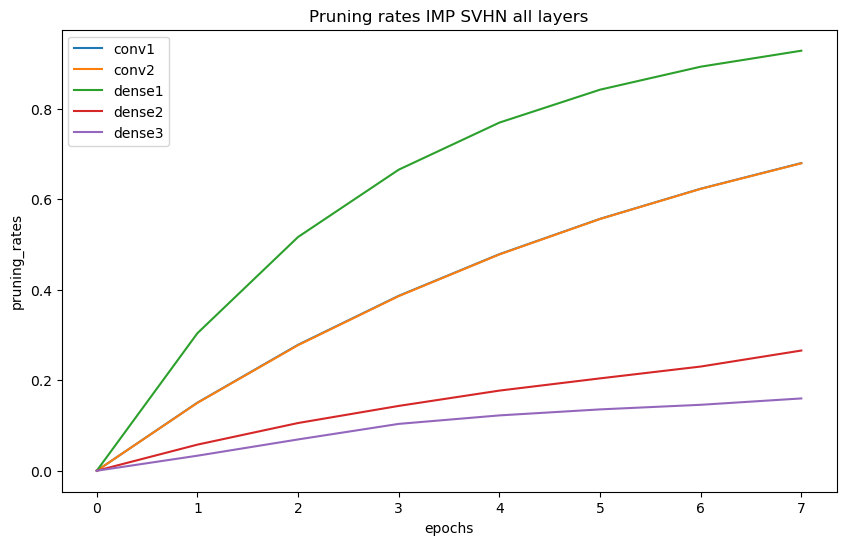

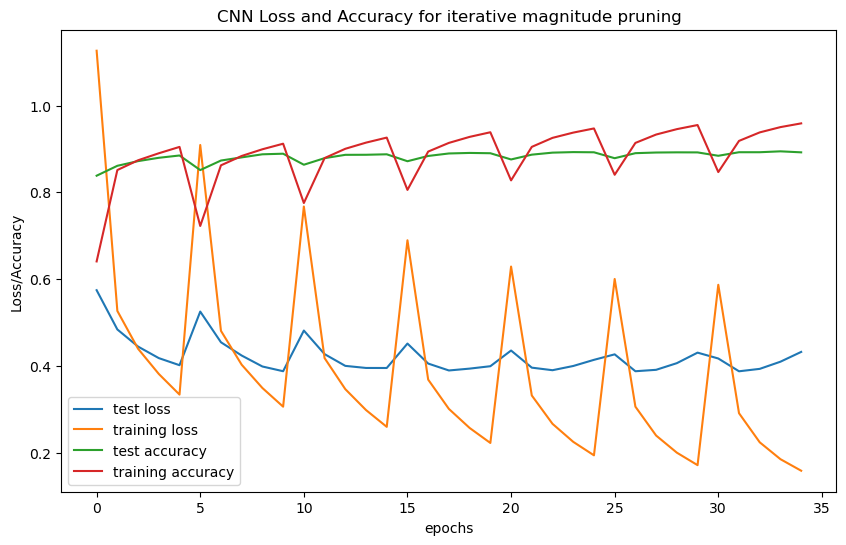

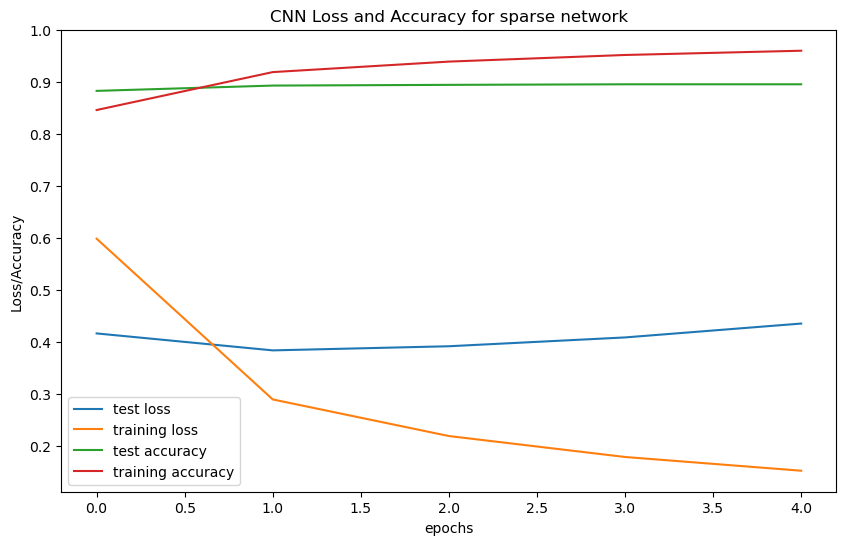

Best accuracy of control model:  0.8849147
Best accuracy of sparse model:  0.8962457
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282960891723633, 0.0, 0.265625, 0.0, 0.15976562500000002, 0.0]
It's a winning ticket!


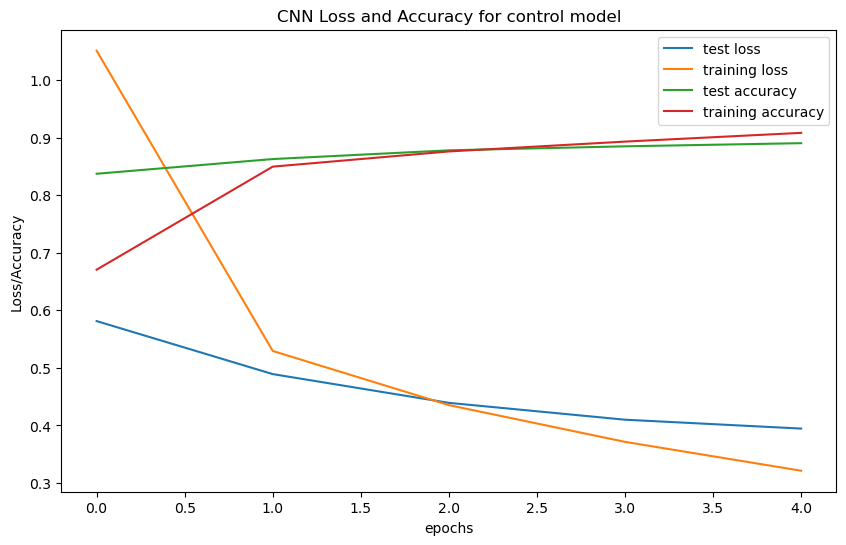

pruning iterations: 100%|██████████| 7/7 [3:34:18<00:00, 1836.97s/it]  


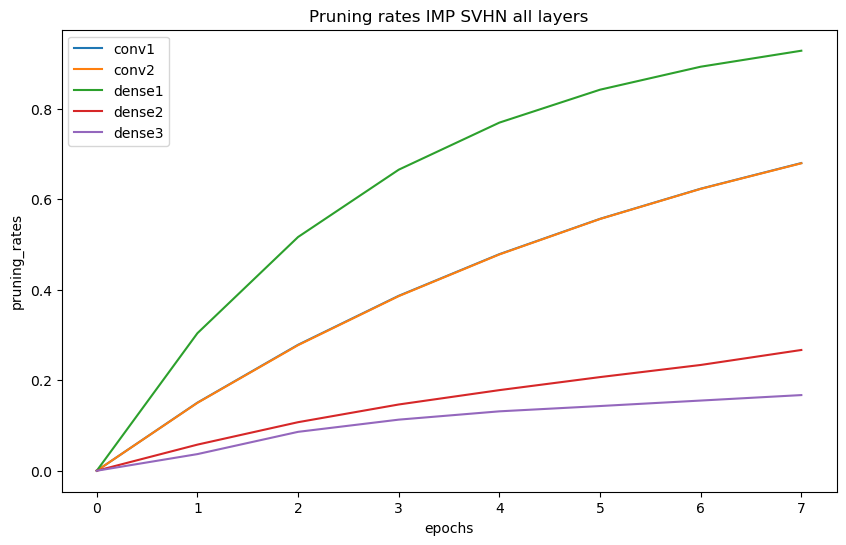

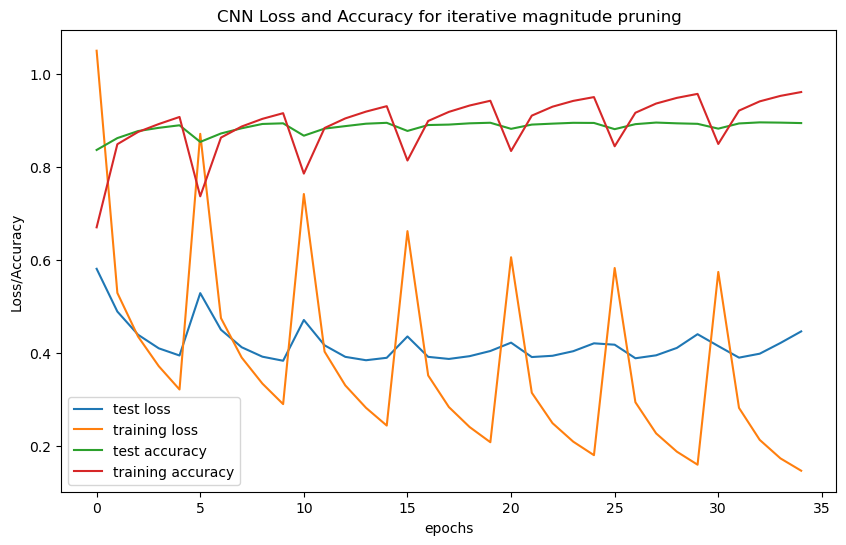

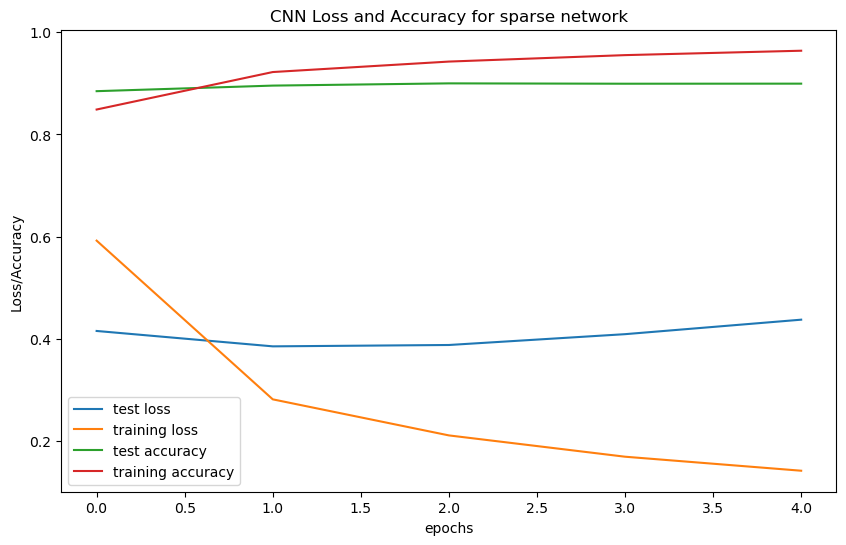

Best accuracy of control model:  0.8902389
Best accuracy of sparse model:  0.8999317
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282722473144531, 0.0, 0.2668609619140625, 0.0, 0.16718750000000004, 0.0]
It's a winning ticket!


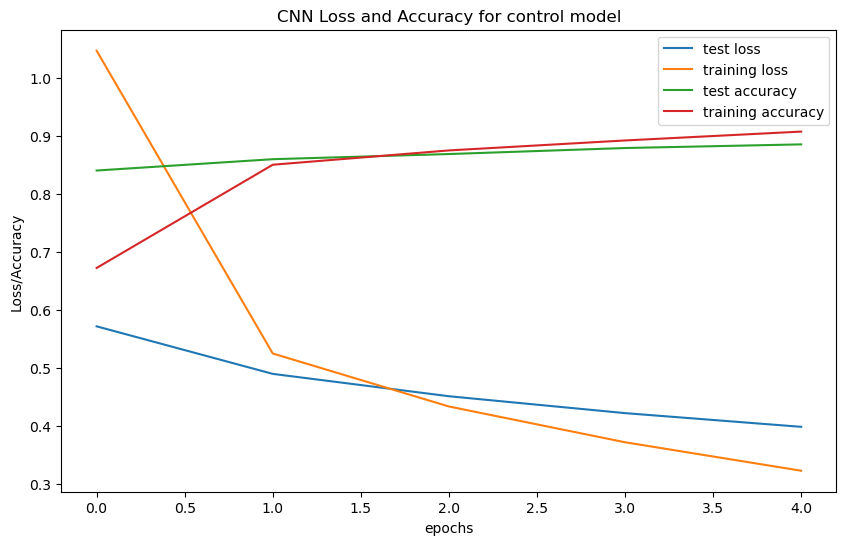

pruning iterations: 100%|██████████| 7/7 [3:27:20<00:00, 1777.22s/it]  


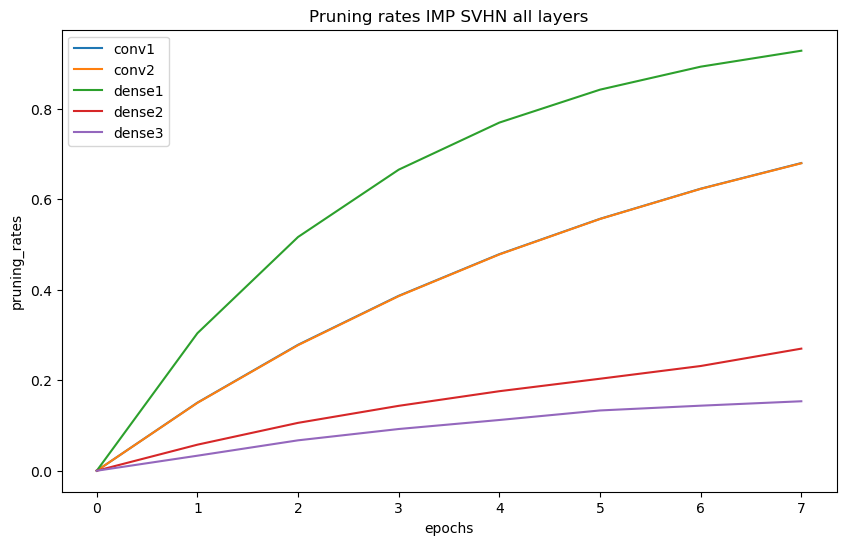

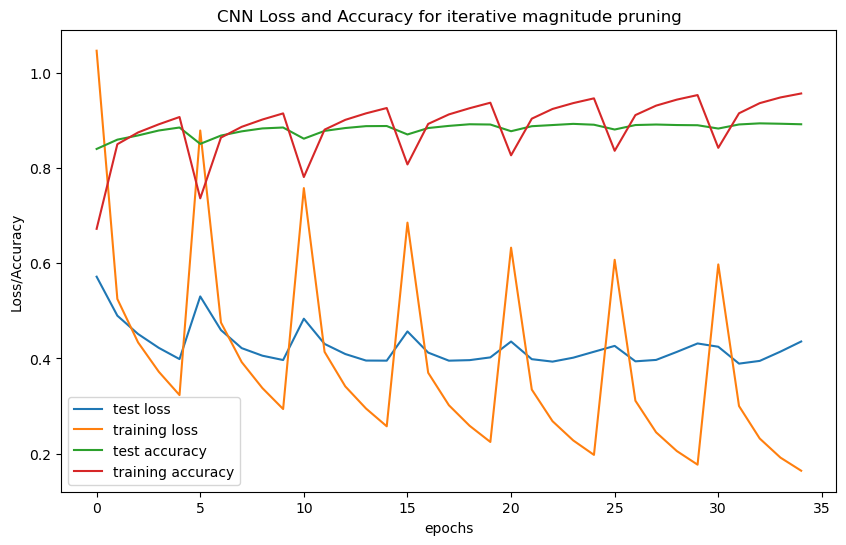

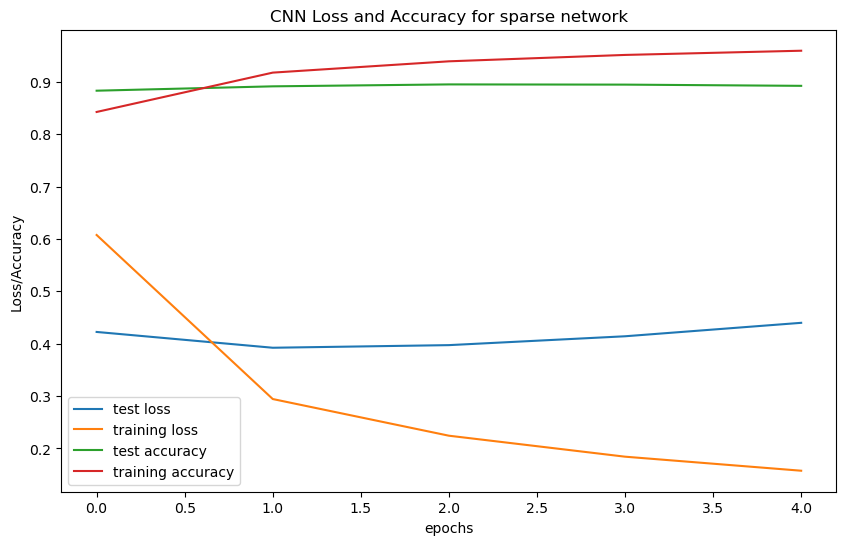

Best accuracy of control model:  0.88532424
Best accuracy of sparse model:  0.8951536
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282345771789551, 0.0, 0.269805908203125, 0.0, 0.15351562500000004, 0.0]
It's a winning ticket!


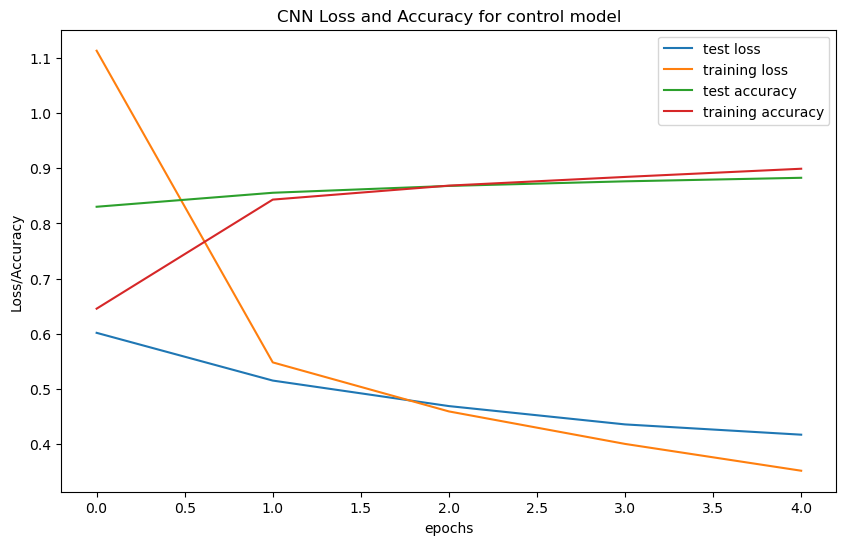

pruning iterations: 100%|██████████| 7/7 [3:32:22<00:00, 1820.35s/it]  


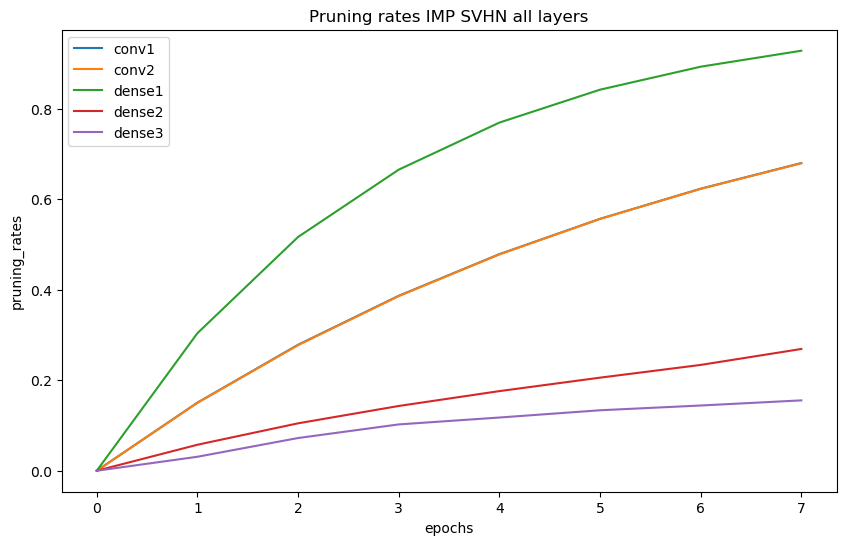

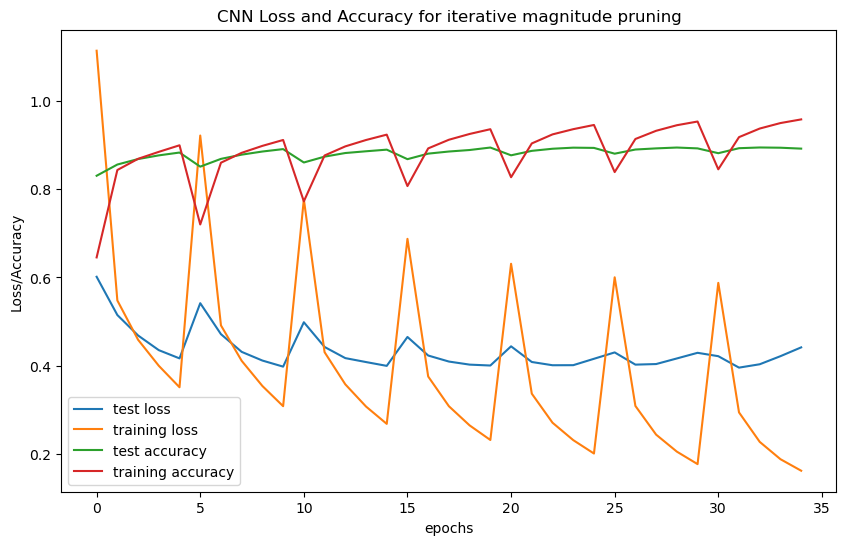

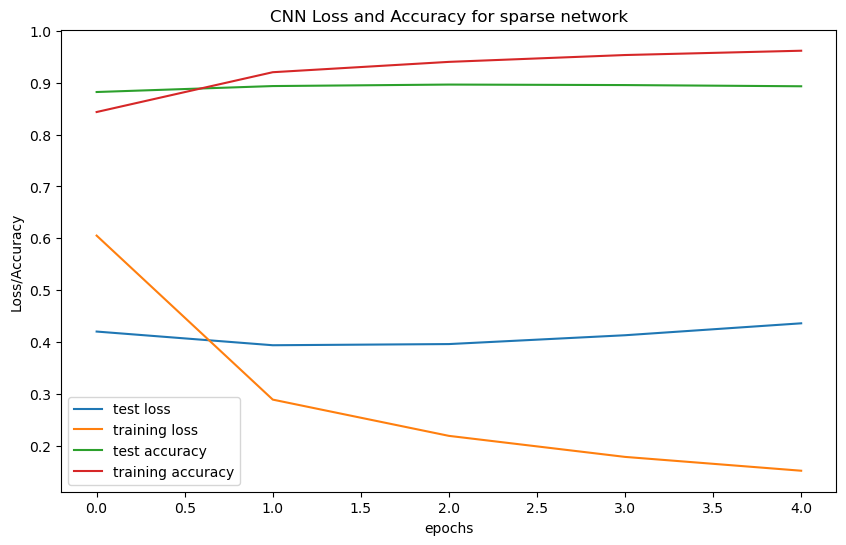

Best accuracy of control model:  0.8828669
Best accuracy of sparse model:  0.8962457
total pruning rate: 0.9153702237424686
layerwise pruning rates: [0.6799768518518519, 0.0, 0.679443359375, 0.0, 0.9282450675964355, 0.0, 0.2690582275390625, 0.0, 0.15546875000000004, 0.0]
It's a winning ticket!


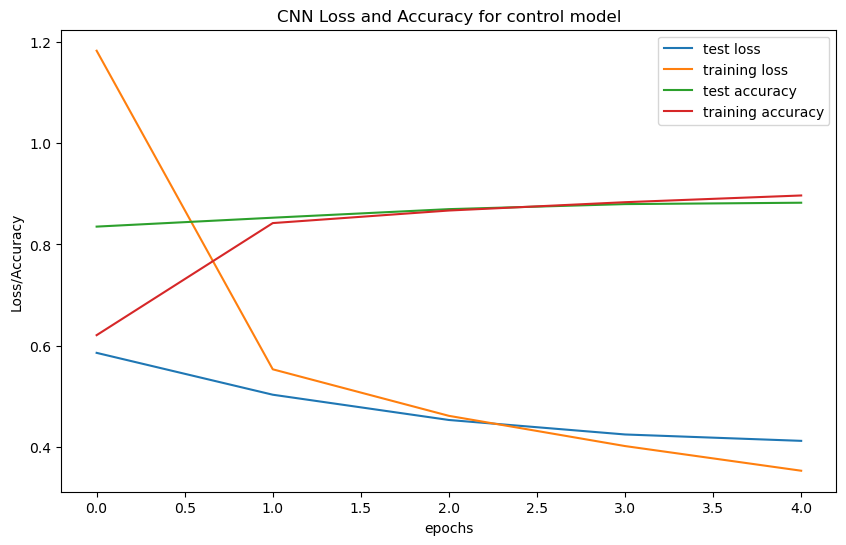

pruning iterations: 100%|██████████| 7/7 [3:24:26<00:00, 1752.30s/it]  


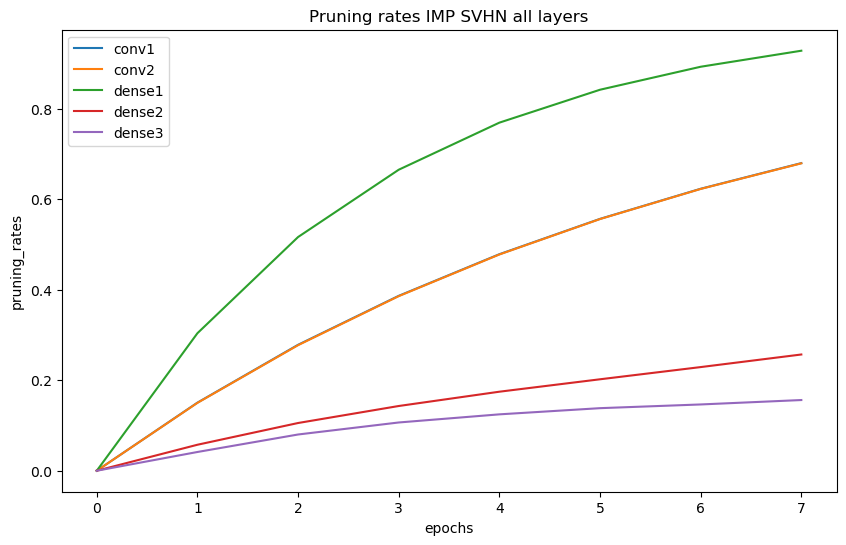

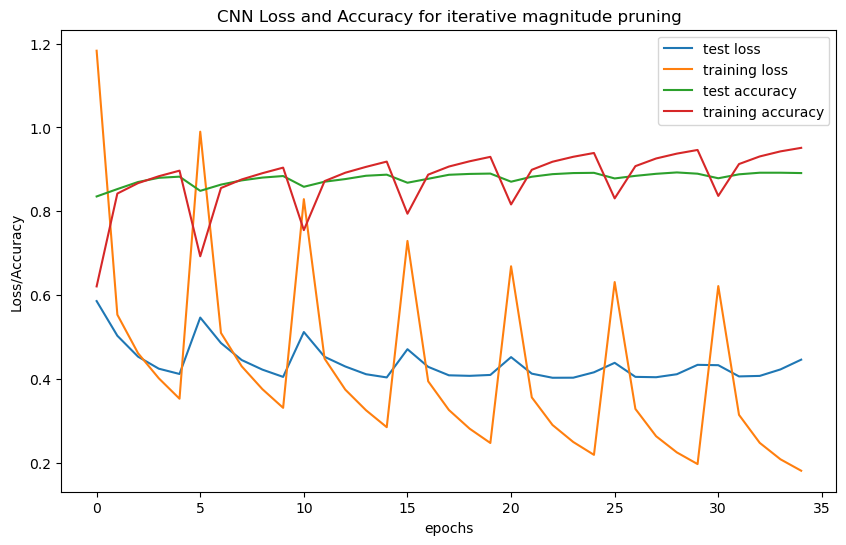

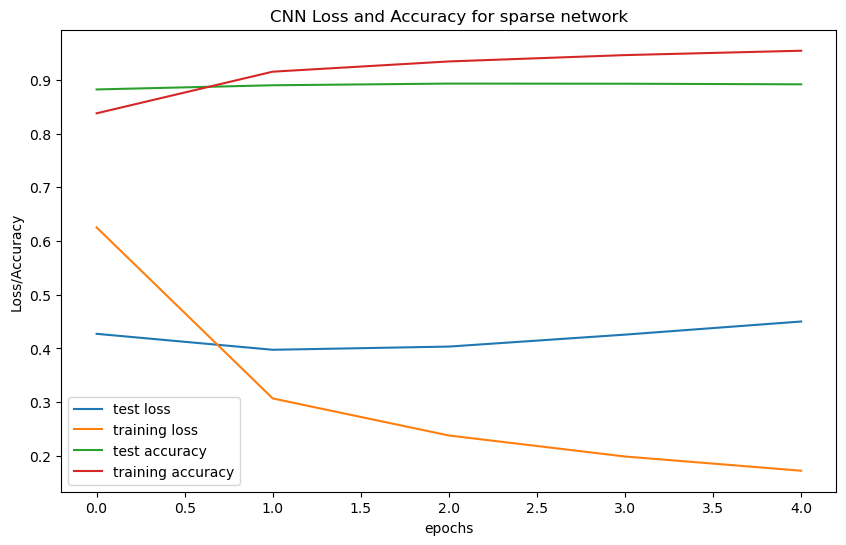

Best accuracy of control model:  0.8824573
Best accuracy of sparse model:  0.8929693
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9284341335296631, 0.0, 0.256927490234375, 0.0, 0.15625, 0.0]
It's a winning ticket!


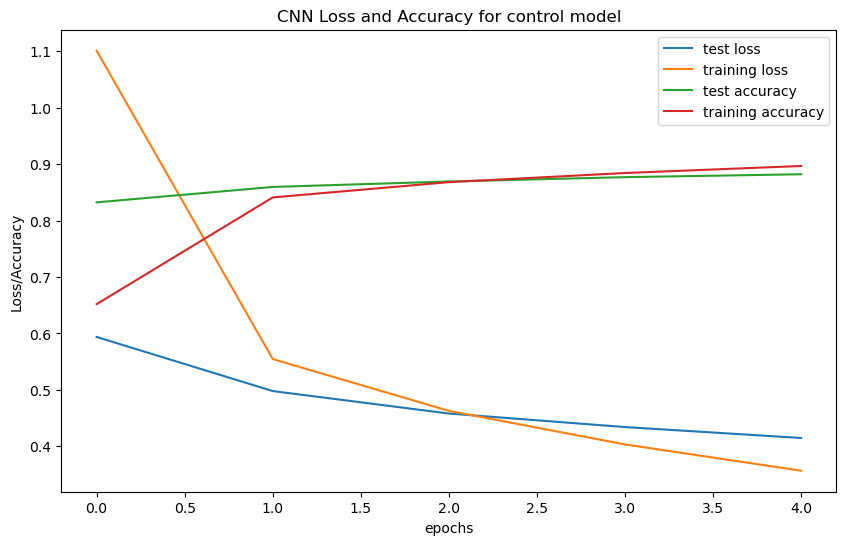

pruning iterations: 100%|██████████| 7/7 [3:16:08<00:00, 1681.24s/it]  


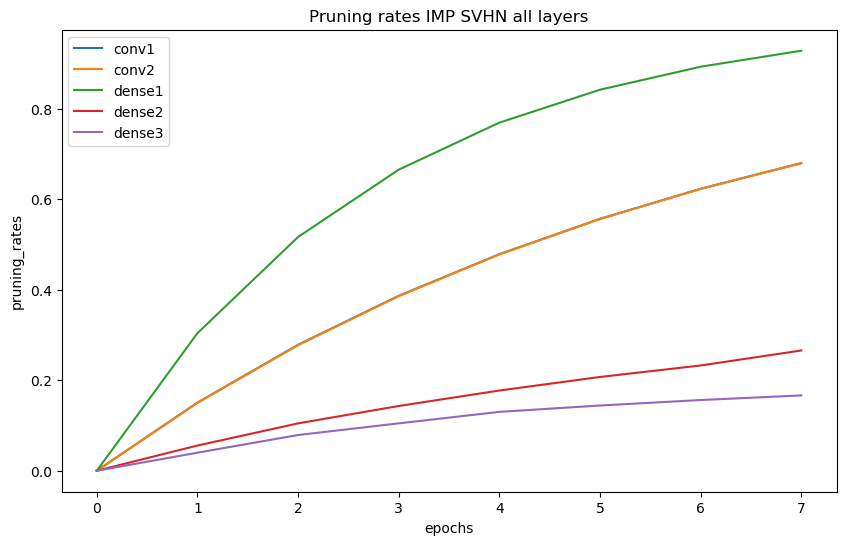

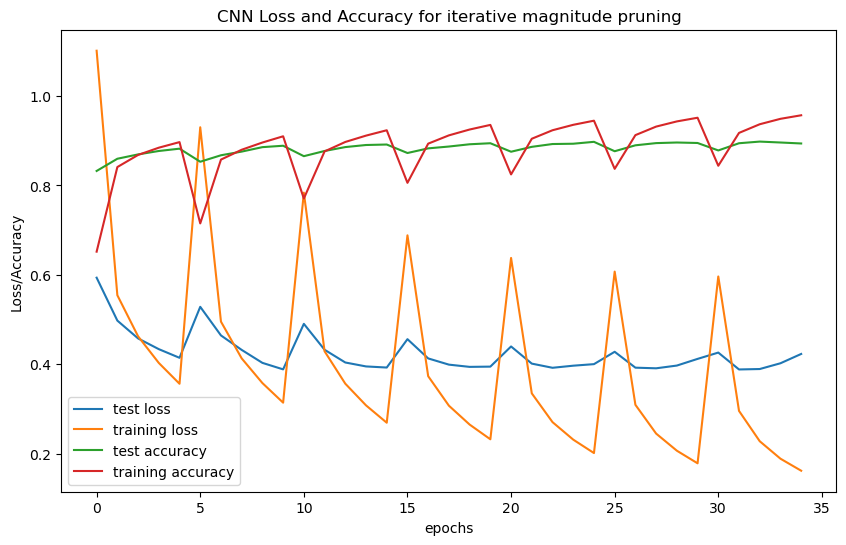

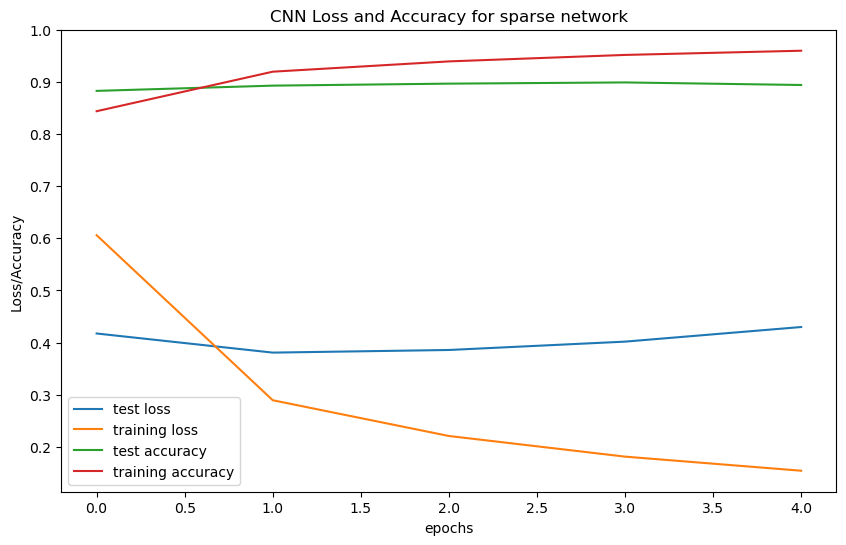

Best accuracy of control model:  0.8821843
Best accuracy of sparse model:  0.8995222
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282894134521484, 0.0, 0.2657928466796875, 0.0, 0.16640624999999998, 0.0]
It's a winning ticket!


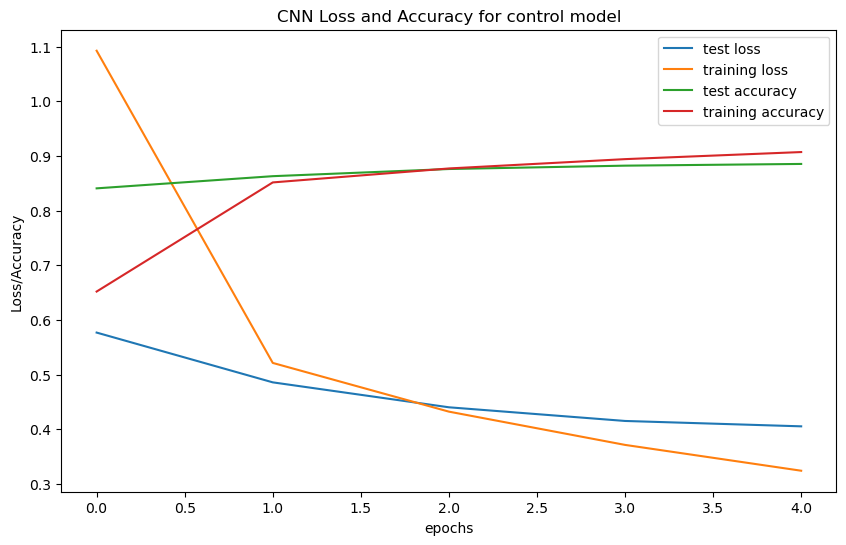

pruning iterations: 100%|██████████| 7/7 [3:20:44<00:00, 1720.68s/it]  


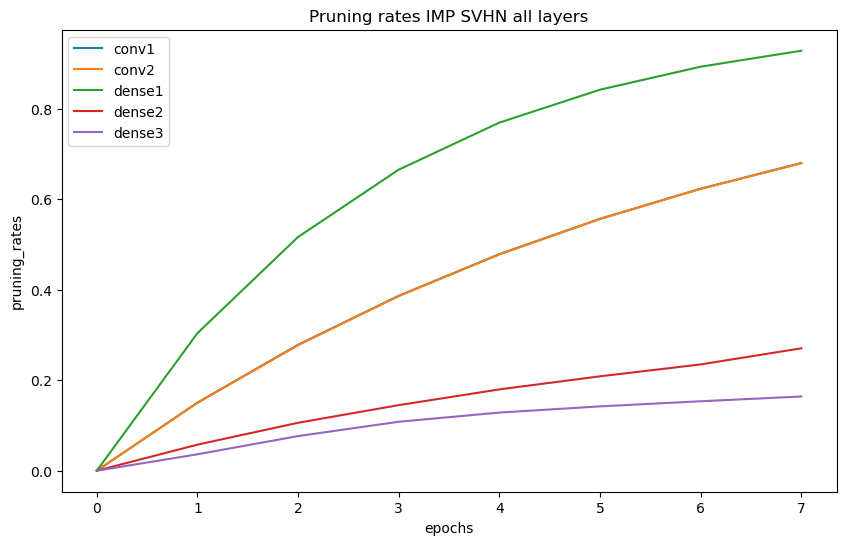

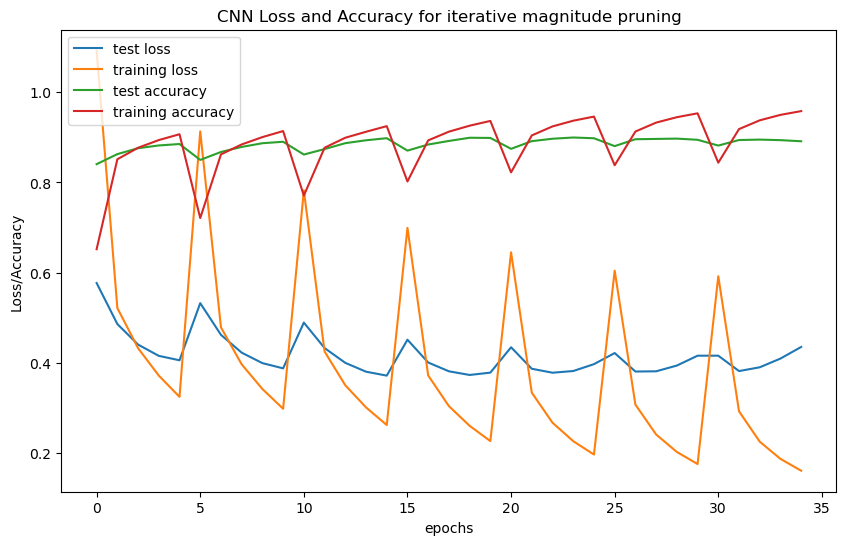

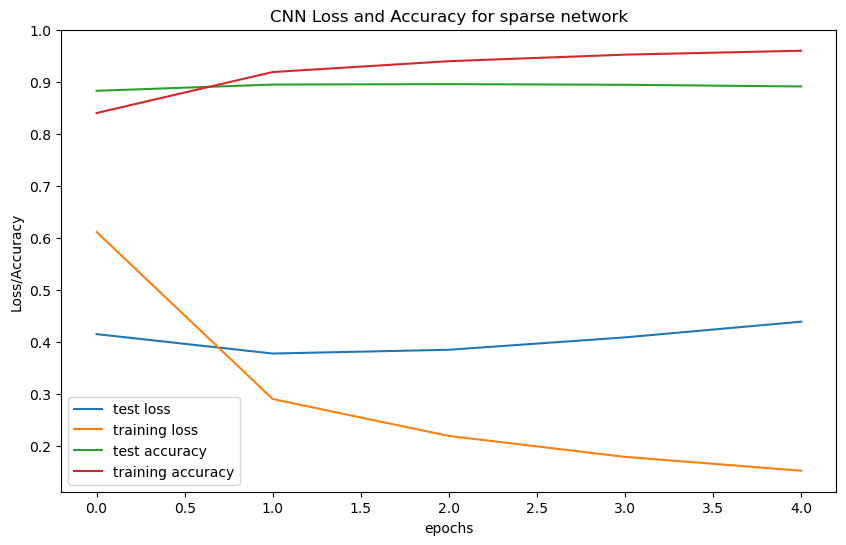

Best accuracy of control model:  0.88532424
Best accuracy of sparse model:  0.8963823
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282166957855225, 0.0, 0.270538330078125, 0.0, 0.1640625, 0.0]
It's a winning ticket!


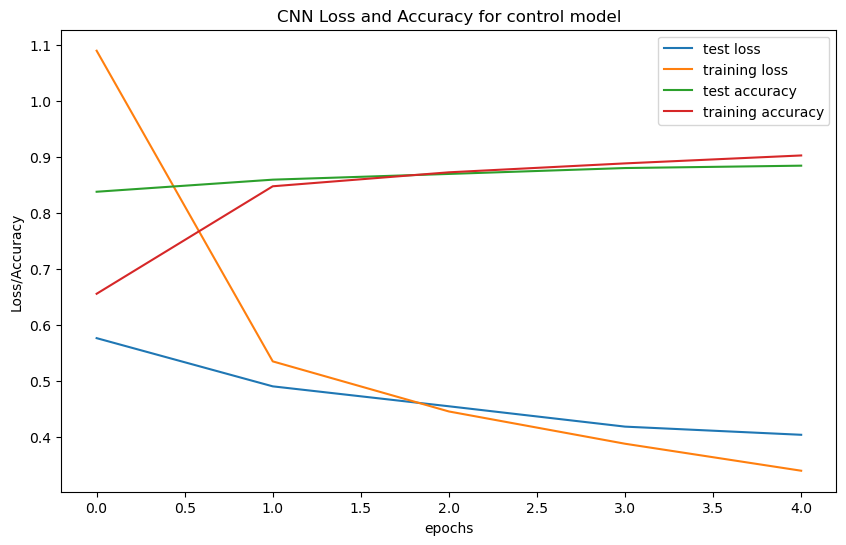

pruning iterations: 100%|██████████| 7/7 [3:13:03<00:00, 1654.83s/it]  


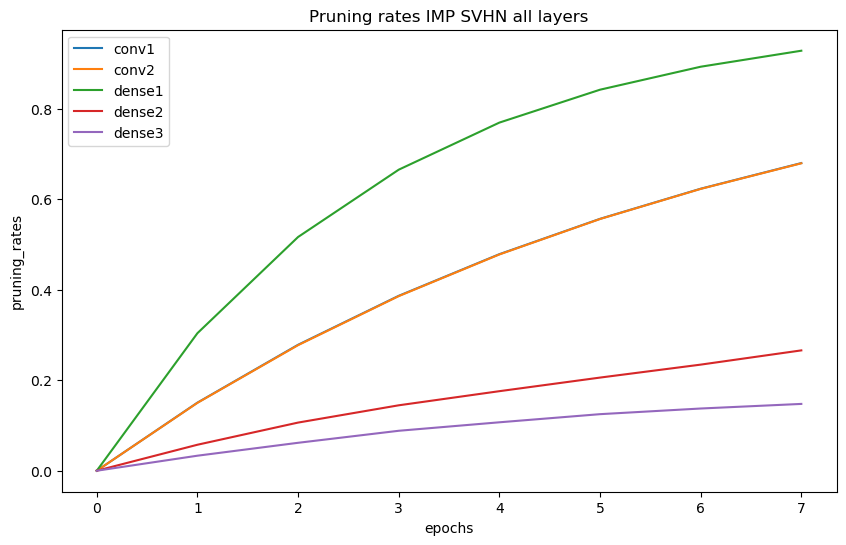

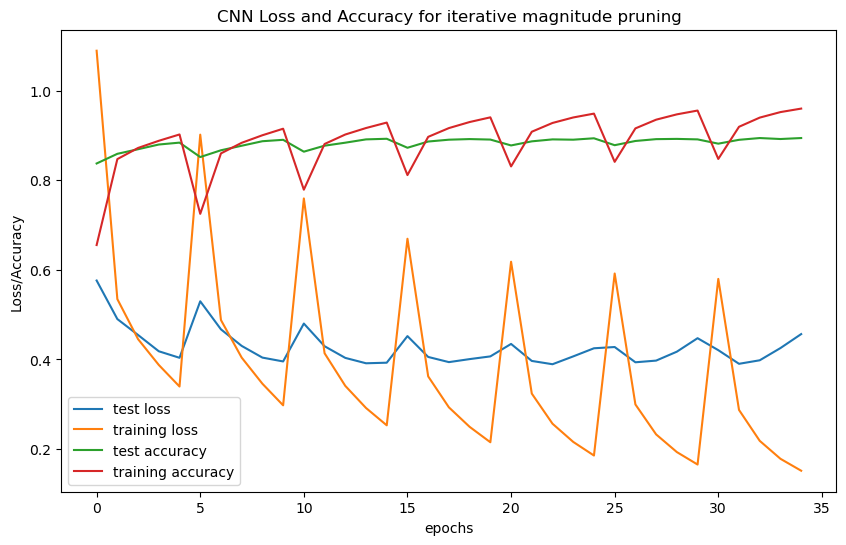

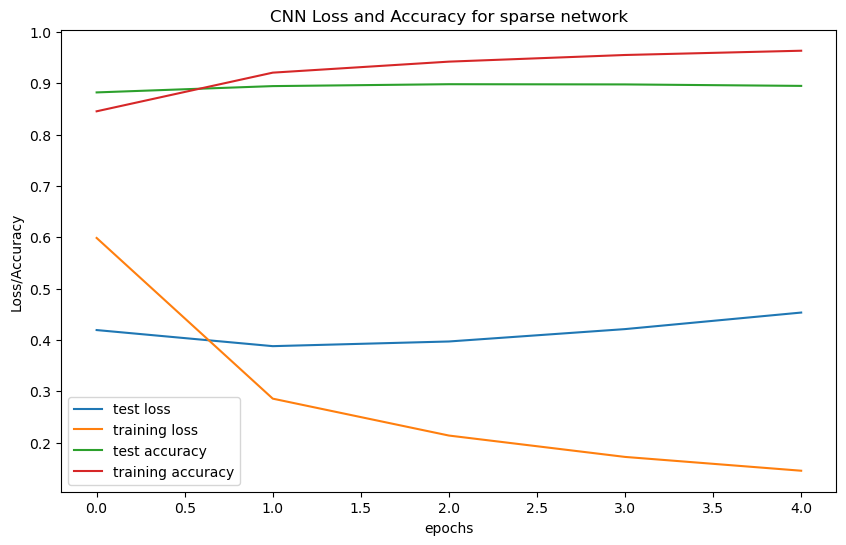

Best accuracy of control model:  0.8842321
Best accuracy of sparse model:  0.8980205
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9282979965209961, 0.0, 0.2659759521484375, 0.0, 0.14765625000000004, 0.0]
It's a winning ticket!


In [8]:
create_lottery_tickets(9, "SVHN")